# Install

In [1]:
!pip install 'git+https://github.com/cene555/ruCLIP-SB.git'

  Cloning https://github.com/cene555/ruCLIP-SB.git to /tmp/pip-req-build-cg43x__s
  Running command git clone -q https://github.com/cene555/ruCLIP-SB.git /tmp/pip-req-build-cg43x__s
     |████████████████████████████████| 431 kB 5.0 MB/s 
     |████████████████████████████████| 3.1 MB 61.4 MB/s 
     |████████████████████████████████| 3.3 MB 36.9 MB/s 
     |████████████████████████████████| 895 kB 51.4 MB/s 
     |████████████████████████████████| 67 kB 3.4 MB/s 
     |████████████████████████████████| 596 kB 50.9 MB/s 
  Created wheel for ruclipsb: filename=ruclipsb-1.0-py3-none-any.whl size=3328 sha256=20a87c79c11d73539f11bed67105e4cf936313058d5202edbdc0b374e66cbdce
  Stored in directory: /tmp/pip-ephem-wheel-cache-ce_dzusv/wheels/6d/97/0f/f70741c9e95bd88c83a32b20d029078aa97fc3e781b4282e9f
Successfully built ruclipsb
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
!pip install pymorphy2

     |████████████████████████████████| 55 kB 2.1 MB/s 
     |████████████████████████████████| 8.2 MB 7.7 MB/s 


In [2]:
!gdown https://drive.google.com/uc?id=1-CghuC9TCIDyn5H3zQS6ho_TNiudzJCX

Downloading...
From: https://drive.google.com/uc?id=1-CghuC9TCIDyn5H3zQS6ho_TNiudzJCX
To: /content/ruCLIP-SB.pkl
100% 159M/159M [00:01<00:00, 117MB/s] 


In [3]:
!gdown https://drive.google.com/uc?id=1ZJhOp5RP5wY31TyJgGNXa9xaJO8SdAhf

Downloading...
From: https://drive.google.com/uc?id=1ZJhOp5RP5wY31TyJgGNXa9xaJO8SdAhf
To: /content/cifar100classes.json
100% 1.63k/1.63k [00:00<00:00, 1.35MB/s]


# Import

In [11]:
import torch
import transformers
from PIL import Image
import transformers
from transformers import BertTokenizer
from torchvision import transforms
from ruclipsb import ruCLIPSB
from ruclipsb.utils import tokenize, _convert_image_to_rgb
try:
    from torchvision.transforms import InterpolationMode
    BICUBIC = InterpolationMode.BICUBIC
except ImportError:
    BICUBIC = Image.BICUBIC
import cv2

In [12]:
torch.manual_seed(1)

In [13]:
device = 'cuda'

# Load model

In [16]:
model = ruCLIPSB().to(device)
model.load_state_dict(torch.load('/content/ruCLIP-SB.pkl'))
model = model.half().eval()

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
tokenizer = BertTokenizer.from_pretrained("cointegrated/rubert-tiny")

Downloading:   0%|          | 0.00/235k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/457k [00:00<?, ?B/s]

In [18]:
transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            _convert_image_to_rgb,
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),])

# Show similarity

In [19]:
import torch
from transformers import GPT2Tokenizer
import json
from pymorphy2 import MorphAnalyzer
import os
import skimage
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from collections import Counter
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor
def show_test_images():
    input_resolution = 224
    preprocess = Compose([
        Resize(input_resolution, interpolation=Image.BICUBIC),
        CenterCrop(input_resolution),
        ToTensor()
    ])
    descriptions = {
        'page': 'страница текста о сегментации',
        'chelsea': 'фото морды полосатого кота',
        'astronaut': 'портрет космонавта с американским флагом',
        'rocket': 'ракета стоит на стартовой площадке',
        'motorcycle_right': 'красный мотоцикл стоит в гараже',
        'camera': 'человек смотрит в камеру на штативе',
        'horse': 'черно-белый силуэт лошади',
        'coffee': 'чашка кофе на блюдце'
    }
    images = []
    texts = []
    plt.figure(figsize=(16, 5))
    img_paths = []

    for filename in [filename for filename in os.listdir(skimage.data_dir) if
                     filename.endswith('.png') or filename.endswith('.jpg')]:
        name = os.path.splitext(filename)[0]
        if name not in descriptions:
            continue
        fn = os.path.join(skimage.data_dir, filename)
        img_paths.append(fn)
        image = preprocess(Image.open(fn).convert('RGB'))
        images.append(fn)
        texts.append(descriptions[name])

        plt.subplot(2, 4, len(images))
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f'{filename}\n{descriptions[name]}')
        plt.xticks([])
        plt.yticks([])

    plt.tight_layout()
    return images, texts

In [20]:
def show_similarity(images, texts, similarity):
    input_resolution = 224
    preprocess = Compose([
        Resize(input_resolution, interpolation=Image.BICUBIC),
        CenterCrop(input_resolution),
        ToTensor()
    ])
    count = len(texts)

    plt.figure(figsize=(20, 14))
    plt.imshow(similarity, vmin=0.1, vmax=0.3)
    plt.yticks(range(count), texts, fontsize=18)
    plt.xticks([])
    for i, image in enumerate(images):
        if isinstance(image, str):
            image = Image.open(image)
            image = preprocess(image.convert('RGB'))
        plt.imshow(image.permute(1, 2, 0), extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin='lower')
    for x in range(similarity.shape[1]):
        for y in range(similarity.shape[0]):
            plt.text(x, y, f'{similarity[y, x]:.2f}', ha='center', va='center', size=12)

    for side in ['left', 'top', 'right', 'bottom']:
        plt.gca().spines[side].set_visible(False)

    plt.xlim([-0.5, count - 0.5])
    plt.ylim([count + 0.5, -2])

    plt.title('Cosine similarity between text and image features', size=20)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


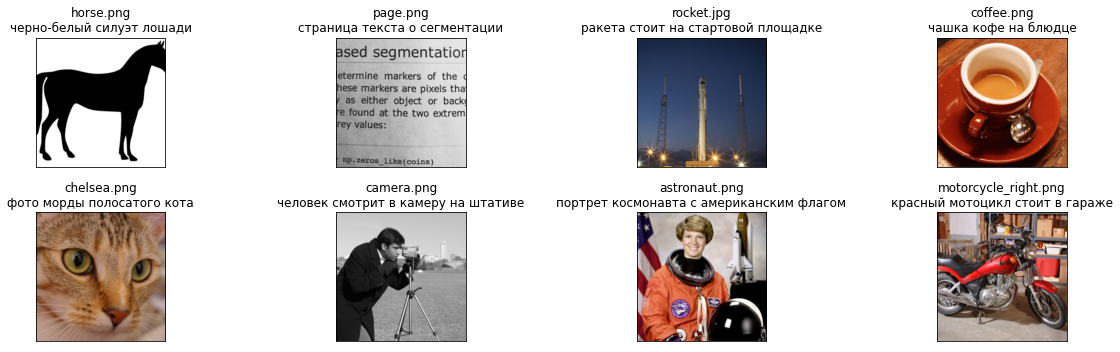

In [21]:
images, texts = show_test_images()

In [22]:
images_test = []
for i in images:
    image = cv2.imread(i)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)
    images_test.append(transform(image))
images_test = torch.stack(images_test, axis=0)

In [23]:
input_ids, attention_mask = tokenize(tokenizer, texts, 77)

In [24]:
with torch.no_grad():
    text_tokens, attention_mask = tokenize(tokenizer, texts, 77)
    text_features = model.encode_text(text_tokens.to(device), attention_mask.to(device)).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)
    image_features = model.encode_image(images_test.to(device)).float()
    text_probs = (1 * image_features @ text_features.T).softmax(dim=-1)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


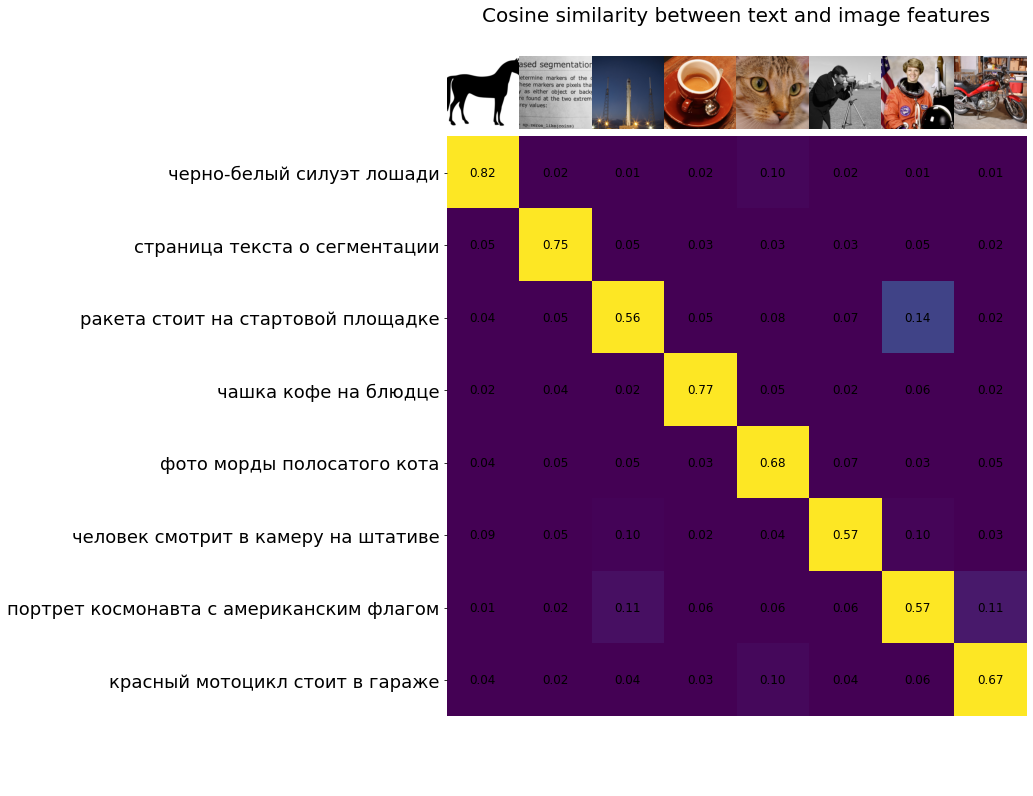

In [25]:
similarity = text_probs.cpu().numpy()
_ = show_similarity(images, texts, similarity)

# Test Cifar100

In [26]:
from torchvision.datasets import CIFAR100
import os
import json
from tqdm.auto import tqdm
import torch
from pymorphy2 import MorphAnalyzer

def prepare_classes(classes, ma=MorphAnalyzer()):
    res = []
    '''
    for cls in classes:
        cls = ma.parse(cls)[0].inflect({"gent"}).word
        res.append(cls)
    '''
    return [f"{label.lower()}" for label in classes]


def get_text_probs_from_dataset(
        model,
        tokenizer=None,
        ds=None,
        train=False,
        classes_path=None,
        text_descriptions=None,
        transform=None
):
    if ds is None:
        cls = CIFAR100
        ds = cls(os.path.expanduser("~/.cache"), download=True, train=train)
        if classes_path is None:
            classes_path = f"../clip/evaluate/{name.lower()}/{name.lower()}classes.json"
        with open(classes_path, "r") as file:
            ds.classes = json.load(file)
    if text_descriptions is None:
        text_descriptions = prepare_classes(ds.classes)
    input_ids, attention_mask = tokenize(tokenizer, text_descriptions, 77)
    probs = []
    labels = []
    with torch.no_grad():
        text_features = model.encode_text(input_ids.to(device), attention_mask.to(device)).float()
        text_features /= text_features.norm(dim=-1, keepdim=True)
        for x in tqdm(ds, total=len(ds)):
            images = [transform(x[0])]
            image_features = model.encode_image(torch.stack(images).to(device)).float()
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_probs = (1 * image_features @ text_features.T).softmax(dim=-1)
            labels.append(x[1])
            probs.append(text_probs.tolist()[0])
    return probs, labels


def get_topk_accuracy(labels, probs, k=5):
    successes = 0
    for lbl, p in zip(labels, np.array(probs)):
        _, top_labels = torch.tensor(p).topk(k, dim=-1)
        if lbl in top_labels:
            successes += 1
    return successes / len(labels)

In [27]:
probs, labels = get_text_probs_from_dataset(
    model, tokenizer,
    classes_path="cifar100classes.json", transform=transform)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


  0%|          | 0/10000 [00:00<?, ?it/s]

In [28]:
get_topk_accuracy(labels, probs, k=5)

0.6322

In [29]:
get_topk_accuracy(labels, probs, k=1)

0.3702